In [4]:
%matplotlib inline
from options.base_options import BaseOptions
from utils.upscale import Upscale
from datasets.climate_dataset import ClimateDataset
from models.edgan import Edgan
from models.gamma_vae import GammaVae

import scipy.stats

import torch
import os
from netCDF4 import Dataset

import matplotlib.pyplot as plt

In [6]:
base_opt = BaseOptions()
opt = base_opt.parse(args=['--batch_size', '64',
                           '--dataroot', 'data/wind_34x34_gamma',
                           '--fine_size', '32',
                           '--gpu_ids', '-1',
                           '--load_epoch', '-1',
                           '--log_interval', '10',
                           '--lr', '0.005',
                           '--model', 'gamma_vae',
                           '--n_epochs', '5',
                           '--n_samples', '3',
                           '--n_test', '2',
                           '--n_threads', '4',
                           '--n_val', '2',
                           '--name', 'vae_12_19_2',
                           '--nf_decoder', '16',
                           '--nf_encoder', '16',
                           '--nz', '10',
                           '--phase', 'val',
                           '--plot_interval', '100',
                           '--results_dir', './results/',
                           '--save_interval', '1', 
                           '--save_latest_interval', '1000',
                           '--scale_factor', '8',
                           '--seed', '1'])
device = torch.device("cuda" if len(opt.gpu_ids) > 0 else "cpu")
upscaler = Upscale(size=opt.fine_size+2*opt.scale_factor, scale_factor=opt.scale_factor, device=device)

# Directory of the saved model
load_root = os.path.join('checkpoints', opt.name)
load_epoch = opt.load_epoch if opt.load_epoch >= 0 else 'latest'
load_name = "epoch_{}.pth".format(load_epoch)
load_dir = os.path.join(load_root, load_name)

climate_data = ClimateDataset(opt=opt, phase=opt.phase)

# large_cell = 48x48, cell = 40x40, small_cell = 32x32
large_cell = opt.fine_size + 2*opt.scale_factor

# load the model
if opt.model == "mse_vae":
    model = Edgan(opt=opt, device=device).to(device)
    model.load_state_dict(torch.load(load_dir, map_location='cpu'))
    model.eval()
elif opt.model == "gamma_vae":
    model = GammaVae(opt=opt, device=device).to(device)
    model.load_state_dict(torch.load(load_dir, map_location='cpu'))
    model.eval()
else:
    raise ValueError("model {} is not implemented".format(opt.model))
    
input_dataset = Dataset(os.path.join(opt.dataroot, 'dataset.nc4'), "r", format="NETCDF4")

------------ Options -------------
batch_size: 64
dataroot: data/wind_34x34_gamma
fine_size: 32
gpu_ids: -1
load_epoch: -1
log_interval: 10
lr: 0.005
model: gamma_vae
n_epochs: 5
n_samples: 3
n_test: 2
n_threads: 4
n_val: 2
name: vae_12_19_2
nf_decoder: 16
nf_encoder: 16
no_orog: False
nz: 10
phase: val
plot_interval: 100
results_dir: ./results/
save_interval: 1
save_latest_interval: 1000
scale_factor: 8
seed: 1
-------------- End ----------------


In [7]:
idx_lat = 0
idx_lon = climate_data.lat_lon_list[idx_lat][0]

# calculate upper left index for cell with boundary values to downscale #todo better formulation
anchor_lat = idx_lat * climate_data.cell_size  + climate_data.scale_factor
anchor_lon = idx_lon * climate_data.cell_size
# select indices for a 48 x 48 box around the 32 x 32 box to be downscaled (with boundary values)
large_cell_lats = [i for i in
                   range(anchor_lat - climate_data.scale_factor,
                         anchor_lat + climate_data.fine_size + climate_data.scale_factor)]
# longitudes might cross the prime meridian
large_cell_lons = [i % 720
                   for i in
                   range(anchor_lon - climate_data.scale_factor,
                         anchor_lon + climate_data.fine_size + climate_data.scale_factor)]
# create output path
print("lat: {}\t lon: {}".format(anchor_lat, anchor_lon))

orog = input_dataset['orog'][large_cell_lats, large_cell_lons]
pr = input_dataset['pr'][:, large_cell_lats, large_cell_lons]
uas = input_dataset['uas'][:, large_cell_lats, large_cell_lons]
vas = input_dataset['vas'][:, large_cell_lats, large_cell_lons]

lat: 8	 lon: 160


In [11]:
t = 120

# create reconstructed image
pr_tensor = torch.tensor(pr[t, :, :], dtype=torch.float32, device=device)
orog_tensor = torch.tensor(orog[opt.scale_factor:-opt.scale_factor,
                           opt.scale_factor:-opt.scale_factor], 
                           dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
uas_tensor = torch.tensor(uas[t, :, :], dtype=torch.float32, device=device)
vas_tensor = torch.tensor(vas[t, :, :], dtype=torch.float32, device=device)


coarse_pr = upscaler.upscale(pr_tensor).unsqueeze(0).unsqueeze(0)
coarse_uas = upscaler.upscale(uas_tensor).unsqueeze(0).unsqueeze(0)
coarse_vas = upscaler.upscale(vas_tensor).unsqueeze(0).unsqueeze(0)

p_list = []
alpha_list = []
beta_list = []
for i in range(opt.n_samples):
    with torch.no_grad():
        p, alpha, beta = model.decode(z=torch.randn(1, opt.nz, 1, 1, device=device),
                                      coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                      coarse_vas=coarse_vas, orog=orog_tensor)
        p_list.append(p)
        alpha_list.append(alpha)
        beta_list.append(beta)

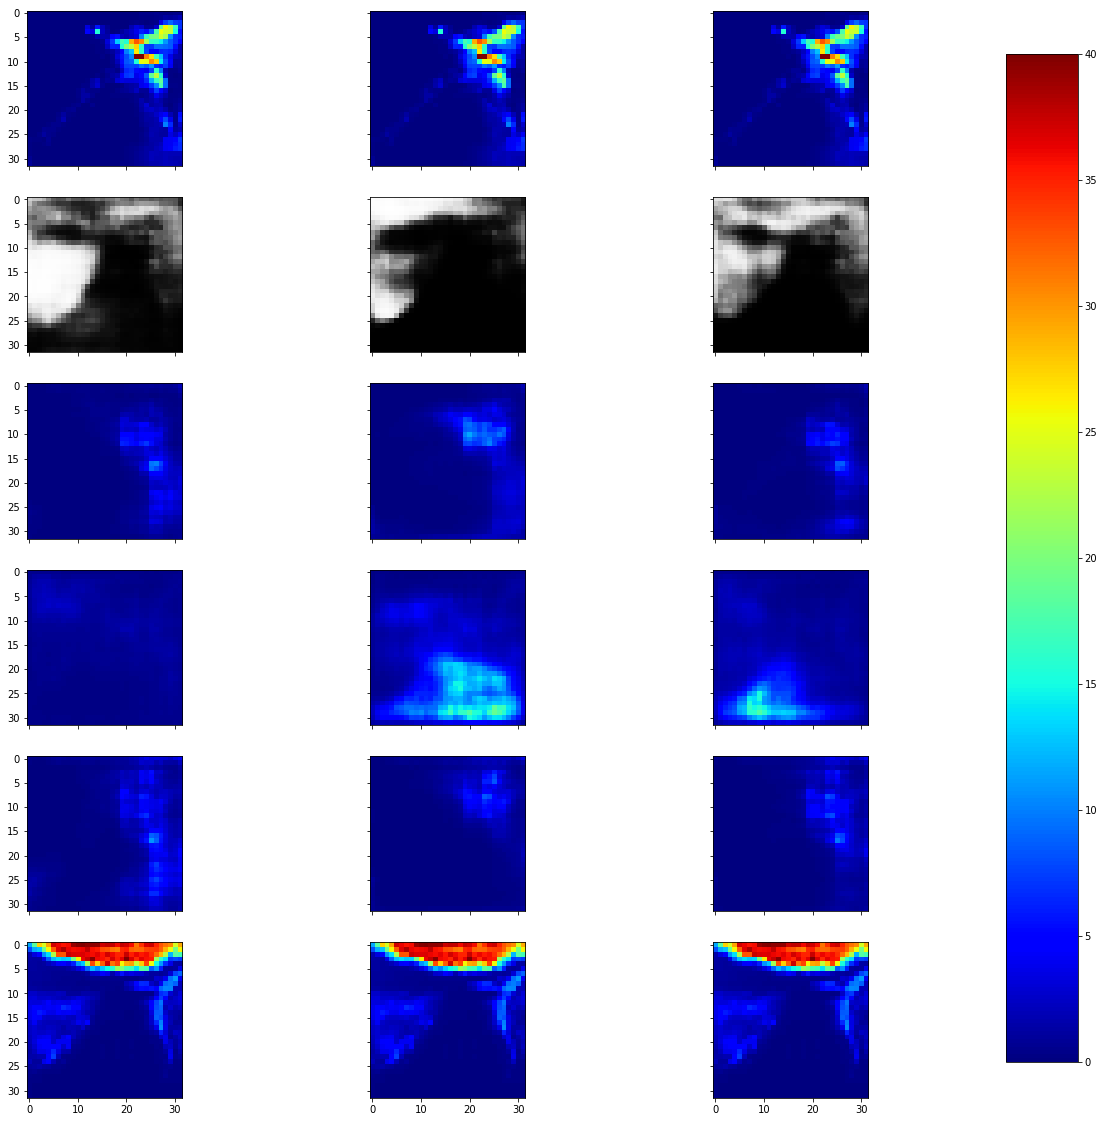

In [12]:
fig, axes = plt.subplots(6, opt.n_samples, sharex='col', sharey='row', figsize = (20, 20))
v_min = 0
v_max = 40
for i in range(opt.n_samples):
    axes[0, i].imshow(pr_tensor[opt.scale_factor:-opt.scale_factor, opt.scale_factor:-opt.scale_factor],
                              cmap=plt.get_cmap('jet'), vmin=v_min, vmax=v_max)
    axes[1, i].imshow(p_list[i][0,0,:,:], cmap=plt.get_cmap('Greys'), vmin=0, vmax=1)
    axes[2, i].imshow((p_list[i]*alpha_list[i]*beta_list[i])[0, 0, :, :], vmin=v_min, vmax=v_max, 
                      cmap=plt.get_cmap('jet'))
    axes[3, i].imshow(alpha_list[i][0,0,:,:], vmin=v_min, vmax=v_max,
                      cmap=plt.get_cmap('jet'))
    im = axes[4, i].imshow(beta_list[i][0,0,:,:], vmin=v_min, vmax=v_max,
                           cmap=plt.get_cmap('jet'))
    axes[5, i].imshow(orog_tensor[0,0,:,:],
                      cmap=plt.get_cmap('jet'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

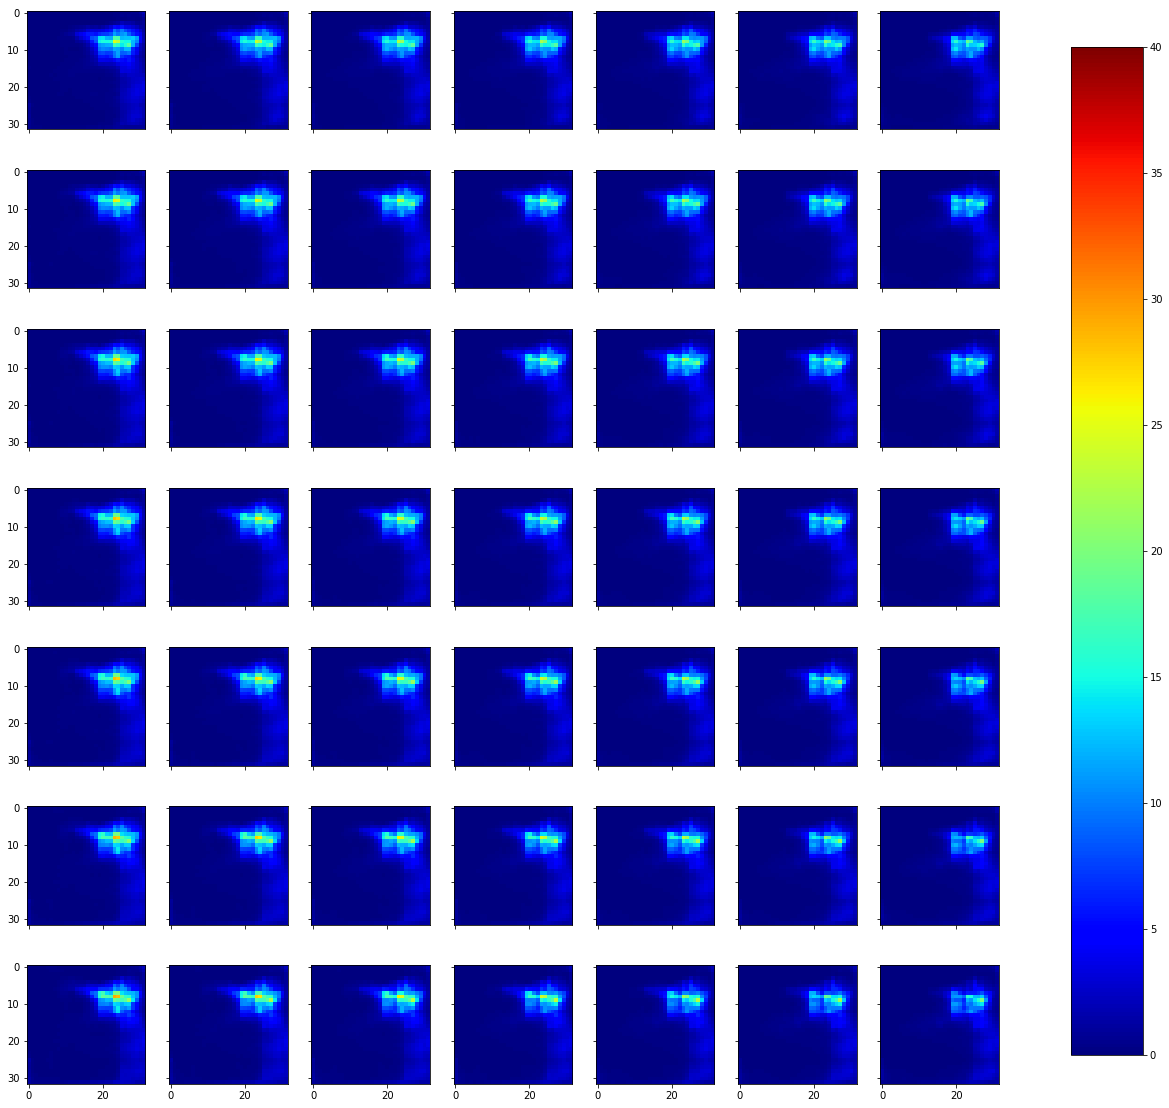

In [17]:
fig, axes = plt.subplots(7, 7, sharex='col', sharey='row', figsize = (20, 20))
z=torch.randn(1, opt.nz, 1, 1, device=device)
for i in range(7):
    for j in range(7):
        z[0,0,0,0] = scipy.stats.norm.ppf((i+1)/8)
        z[0,8,0,0] = scipy.stats.norm.ppf((j+1)/8)
        with torch.no_grad():
            p, alpha, beta = model.decode(z=z,
                                          coarse_pr=coarse_pr,coarse_uas=coarse_uas,
                                          coarse_vas=coarse_vas, orog=orog_tensor)
        axes[i, j].imshow((p 
                           * alpha * beta
                          )[0,0,:,:], vmin=v_min, vmax=v_max,cmap=plt.get_cmap('jet'))
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)